# Impact of variants

We want to infer the effect of different variants onto the reproduction number. Given the positive tested COVID cases in a country we can infer the overall non variant specific effective spreading rate/reproduction number as described in \cite{dehning2020inferring}. 

Now let $y_v$ be the number of sequenced PCR tests, which correspond to variant $v$, let $n$ be the total number of sequenced tests and $\tau_{v,t}$ the relative fraction of the variant $v$ at timepoint $t$.
Assuming an independent sampling of the sequenced cases, the number of samples of a given variant $v$ is given by a Binomial distribution:

\begin{align}
 y_{v,t} \sim \text{Bin}(\tau_{v,t},n_t) \quad \forall v,t.
\end{align}


In [1]:
### Imports
import sys

sys.path.append("./covid19_inference")
import covid19_inference

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pickle
import os
import covid19_inference as cov19
from matplotlib.dates import DateFormatter,WeekdayLocator

n_threads = str(1) # per process
n_processes = 32
os.environ["MKL_NUM_THREADS"] = n_threads
os.environ["OMP_NUM_THREADS"] = n_threads
os.environ["NUMEXPR_NUM_THREADS"] = n_threads
os.environ["OPENBLAS_NUM_THREADS"] = n_threads

### Preprocess data

Here we load the variant data for chile i.e. $y_{v,t}$ and $n_{v,t}$. The resolution for the data is weekly, starting on mondays. Additionaly we download the new confirmed cases in chile with our previous developed download utils. You can find the documentation for the dataretrieval module [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).

In [2]:
# Load data variants
variants = pd.read_excel("./data/Chile_Variants_Updated_070721.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]
variant_names = ["B.1.1", "B.1.1.348", "B.1.1.7", "C.37", "P.1"]

# Load casenumbers chile and sum over weeks
jhu = covid19_inference.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(country="Chile",data_begin=variants.index[0],data_end=variants.index[-1])

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


Let us take a short look into the data. We plot the total number of sampled pcr test such as the number of test which could be per variant and the reported cases in chile.

<ipython-input-24-24b982e2ac31>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


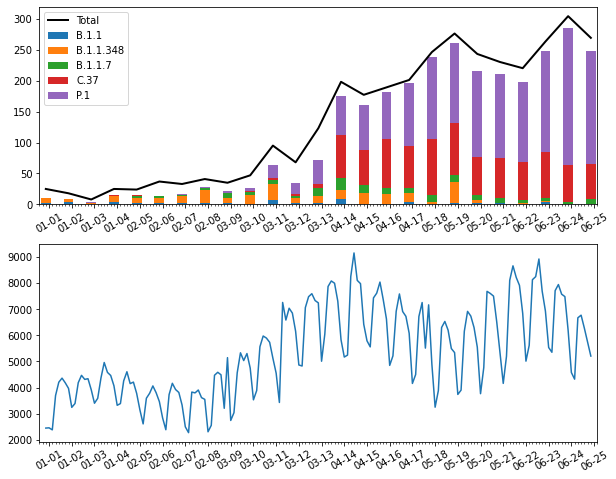

In [24]:
fig, axes = plt.subplots(2,1,figsize=(10,8))

s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    axes[0].bar(variants.index,variants[c],width=3,label=c,bottom=s)
    s += variants[c]
axes[0] = covid19_inference.plot._timeseries(
    x=variants.index,
    y=variants["N_Total"],
    what="model",
    color="black",
    ax=axes[0],
    label="Total",
    lw=2
)
axes[0].legend()
axes[1] = covid19_inference.plot._timeseries(
    x=new_cases_obs.index,
    y=new_cases_obs,
    what="model",
    color="tab:blue",
    ax=axes[1],
)

# Date layout
date_form = DateFormatter("%m-%V")

# Markup
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(variants.index[0]-timedelta(days=2), variants.index[-1]+timedelta(days=2))

fig.savefig("figures/overview.png",dpi=300)
fig.savefig("figures/overview.pdf",dpi=300)

### Create model

We defined different models and tested which one fits the dynamics best, have a look into `run_model.py` for more informations. For now we are running the default model with dirichlet likelihood and kernelized spread.

In [42]:
from run_model import create_model

this_model = create_model(
    likelihood="dirichlet",
    spreading_dynamics="SIR",
    variants=variants,
    new_cases_obs=new_cases_obs
)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.compartmental_models] SIR with variants
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


[2450. 2460. 2382. 3693. 4205. 4361. 4181. 3969. 3243. 3390. 4187. 4468.
 4313. 4339. 3918. 3401. 3589. 4367. 4959. 4581. 4463. 4068. 3322. 3388.
 4255. 4606. 4151. 4209. 3779. 3147. 2610. 3592. 3782. 4063. 3804. 3464.
 2839. 2387. 3731. 4164. 3925. 3813. 3332. 2498. 2275. 3828. 3797. 3906.
 3615. 3549. 2308. 2555. 4472. 4585. 4489. 3207. 5145. 2742. 3040. 4567.
 5331. 5033. 5302. 4748. 3531. 3885. 5563. 5973. 5894. 5731. 5121. 4551.
 3430. 7257. 6584. 7036. 6850. 6155. 4864. 4825. 7060. 7478. 7592. 7330.
 7241. 5008. 6046. 7868. 8079. 7993. 7307. 5827. 5168. 5242. 8248. 9151.
 8101. 7977. 6421. 5790. 5557. 7431. 7613. 8037. 7370. 6622. 4849. 5214.
 6917. 7582. 6909. 6725. 6078. 4158. 4499. 6720. 7254. 5510. 7165. 4895.
 3249. 3885. 6299. 6530. 6198. 5493. 5339. 3738. 3902. 6153. 6915. 6736.
 6296. 5548. 3766. 4767. 7682. 7602. 7500. 6505. 5343. 4160. 5197. 8105.
 8658. 8216. 7910. 6839. 5011. 5616. 8128. 8245. 8920. 7690. 6928. 5533.
 5351. 7709. 7942. 7573. 7481. 6190. 4576. 4322. 66

## Sampling

In [43]:
from pymc3 import sample
trace = sample(
    model=this_model,
    return_inferencedata=True,
    cores=n_processes,
    chains=4,
    draws=100,
    tune=100,
    #init="advi+adapt_diag"
)

WARNING  [pymc3] Only 100 samples in chain.
INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Multiprocess sampling (4 chains in 32 jobs)
INFO     [pymc3] NUTS: [factor_likelihood, sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, Phi, I_begin_v, I_begin_ratio_log, mu, f_v, un_transient_len_9_log_, un_transient_len_8_log_, un_transient_len_7_log_, un_transient_len_6_log_, un_transient_len_5_log_, un_transient_len_4_log_, un_transient_len_3_log_, un_transient_len_2_log_, un_transient_len_1_log_, un_transient_day_9, un_transient_day_8, un_transient_day_7, un_transient_day_6, un_transient_day_5, un_transient_day_4, un_transient_day_3, un_transient_day_2, un_transient_day_1, un_lambda_9_log_, un_lambda_8_log_, un_lambda_7_log_, un_lambda_6_log_, un_lambda_5_log_, un_lambda_4_log_, un_lambda_3_log_, un_lambda_2_log_, un_lambda_1_log_, un_lambda_0_log_, transient_len_17_log_, transient_len_16_log_, tr

INFO     [pymc3] Sampling 3 chains for 100 tune and 100 draw iterations (300 + 300 draws total) took 889 seconds.


IndexError: index 3 is out of bounds for axis 0 with size 3

In [6]:
import pickle
# Save the trace (maybe we want to load it at a later point)
with open("./pickled/trace-likelihood=binom-spread_method=kernelized.pickle", 'wb') as f:
    pickle.dump((this_model,trace),f)


NameError: name 'trace' is not defined

In [30]:
import pickle
with open("./pickled/Variants-likelihood=beta-spread_method=SIR.pickle", "rb") as f:
    this_model, trace = pickle.load(f)

In [ ]:
_ = plt.plot(trace.sample_stats["lp"].T)

In [32]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

## Stats and plots

First let's have a look if our chains converged to approx the same values. We can do that by computing the Rhat statistic.

In [33]:
import arviz as az
az.rhat(trace).max()

<xarray.Dataset>
Dimensions:                  ()
Data variables: (12/188)
    lambda_0_log_            float64 1.091
    lambda_1_log_            float64 1.105
    lambda_2_log_            float64 1.099
    lambda_3_log_            float64 1.111
    lambda_4_log_            float64 1.125
    lambda_5_log_            float64 1.146
    ...                       ...
    offset_modulation_rad    float64 1.113
    offset_modulation        float64 1.113
    new_cases                float64 1.47
    sigma_obs                float64 1.391
    tau                      float64 1.491
    tau_w                    float64 1.317

Next we want to create some basic plots, given our data and the model predictions. 

<ipython-input-34-4bf22d983139>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


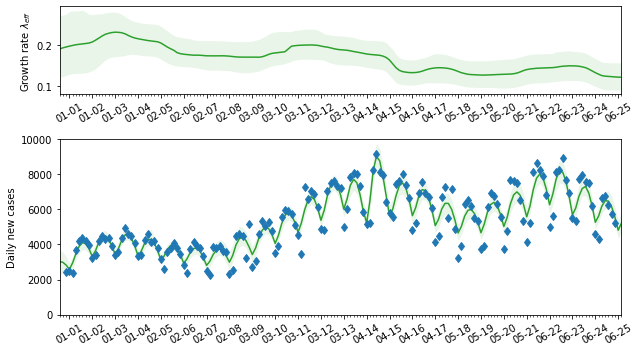

In [34]:


def plot_timeseries(trace, model, key, var=None, ax=None, **kwargs):
    # Get data
    if var is None:
        var = np.array(trace.posterior[key])
        var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,8))

    axes = cov19.plot._timeseries(
        x=pd.date_range(this_model.sim_begin,this_model.sim_end),
        y=var[:,:],
        what="model",
        ax=ax,
        **kwargs
    )

    return axes

fig, axes = plt.subplots(2,1,figsize=(9,5), gridspec_kw={'height_ratios': [1, 2]})

# Plot new_cases
ax = plot_timeseries(trace,this_model,"new_cases",ax=axes[1])
cov19.plot._timeseries(new_cases_obs.index, new_cases_obs,what="data", ax=ax)
ax.set_ylim(0,10000)
ax.set_ylabel("Daily new cases")

# Plot lambda_t
ax = plot_timeseries(trace,this_model,"base_lambda_t",ax=axes[0])
ax.set_ylabel("Growth rate $\lambda_{eff}$")



for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
fig.tight_layout()

fig.savefig("./figures/lambda+cases.png",dpi=300)
fig.savefig("./figures/lambda+cases.pdf",dpi=300)

Text(0, 0.5, 'Growth rate $\\lambda_{eff}$')

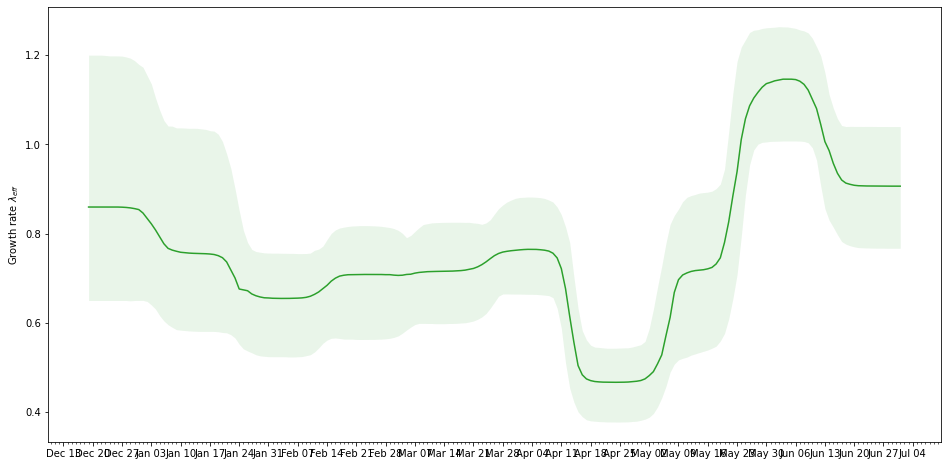

In [35]:
# Plot lambda_t
ax = plot_timeseries(trace,this_model,"unknown_lambda_t")
ax.set_ylabel("Growth rate $\lambda_{eff}$")

<ipython-input-36-6533150061fd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


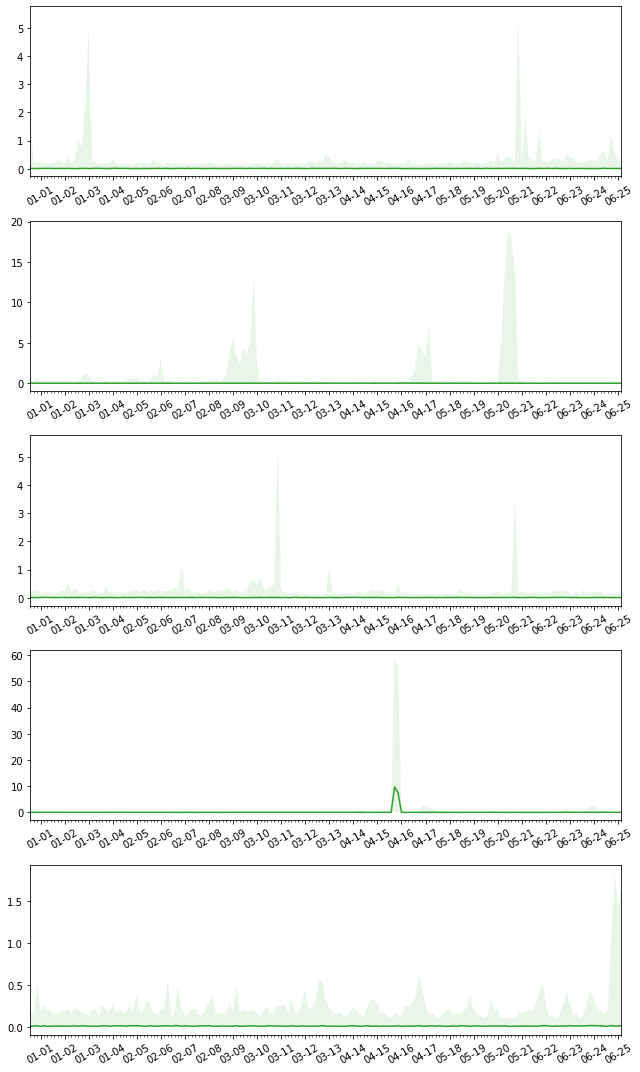

In [36]:
var = np.array(trace.posterior["Phi"])
var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])

fig, axes = plt.subplots(5,1,figsize=(9,3*5))
for v in range(len(variant_names)):
    plot_timeseries(trace,this_model,var=var[:,:,v], key="Phi",ax=axes[v])

for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
fig.tight_layout()

fig.savefig("./figures/influx.png",dpi=300)
fig.savefig("./figures/influx.pdf",dpi=300)

<ipython-input-37-c6b45cf129f0>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=30)


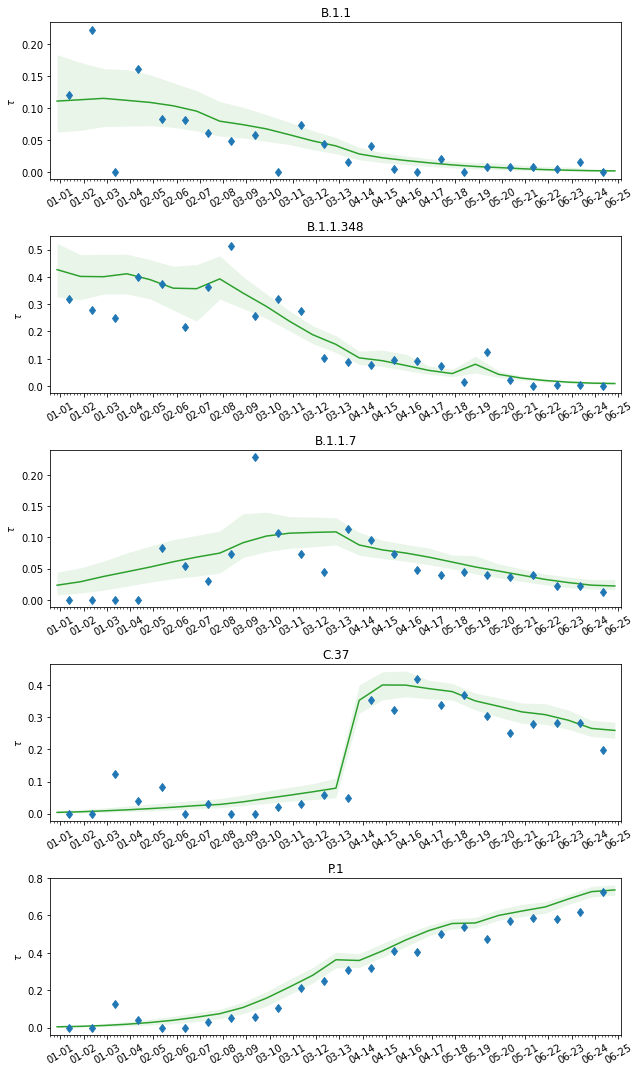

In [37]:
fig, axes = plt.subplots(len(variant_names),1,figsize=(9,3*5))
for v, variant in enumerate(variant_names):
    ax = cov19.plot._timeseries(
        x=variants.index,
        y=np.array(trace.posterior.tau_w).reshape((trace.posterior.tau_w.shape[0]*trace.posterior.tau_w.shape[1],trace.posterior.tau_w.shape[2],trace.posterior.tau_w.shape[-1],))[:,:,v],
        what="model",
        ax=axes[v]
    )
    ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=variants[variants.columns[v]]/variants["N_Total"],
            what="data",
        ax=ax
    )
    ax.set_title(variant)
    
for ax in axes:
    ax.set_xticklabels(ax.get_xticks(), rotation=30)
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))
    _ = ax.set_xlim(this_model.data_begin-timedelta(days=2), this_model.data_end+timedelta(days=2))
    
    # 
    ax.set_ylabel(r"$\tau$")
fig.tight_layout()
fig.savefig("./figures/tau.png",dpi=300)
fig.savefig("./figures/tau.pdf",dpi=300)

In [38]:
np.array(trace.posterior.tau).reshape((trace.posterior.tau.shape[0]*trace.posterior.tau.shape[1],trace.posterior.tau.shape[2],trace.posterior.tau.shape[-1],))[:,:,v].mean()

0.3121561333089315

/home/smohr/anaconda3/envs/soccer/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


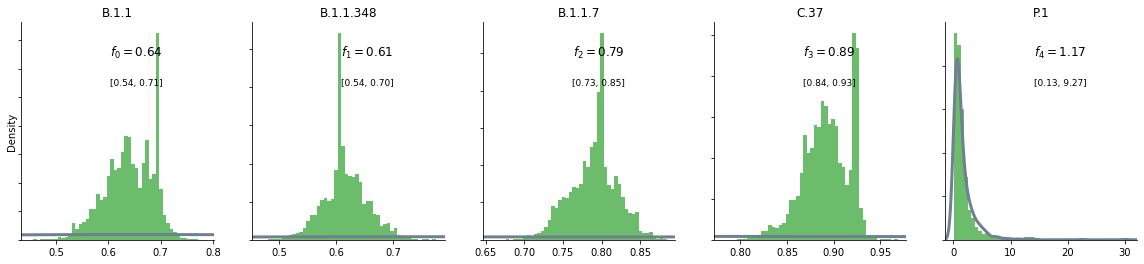

In [39]:
import plot as pl
from rcParams import *

axes = pl.distribution(this_model, trace, "f_v", title="", dist_math="f",)
fig = axes[0].get_figure()

for i, var in enumerate(variant_names):
    axes[i].set_title(var)
    
axes[0].set_ylabel("Density")

fig.savefig("./figures/f.png",dpi=300)
fig.savefig("./figures/f.pdf",dpi=300)

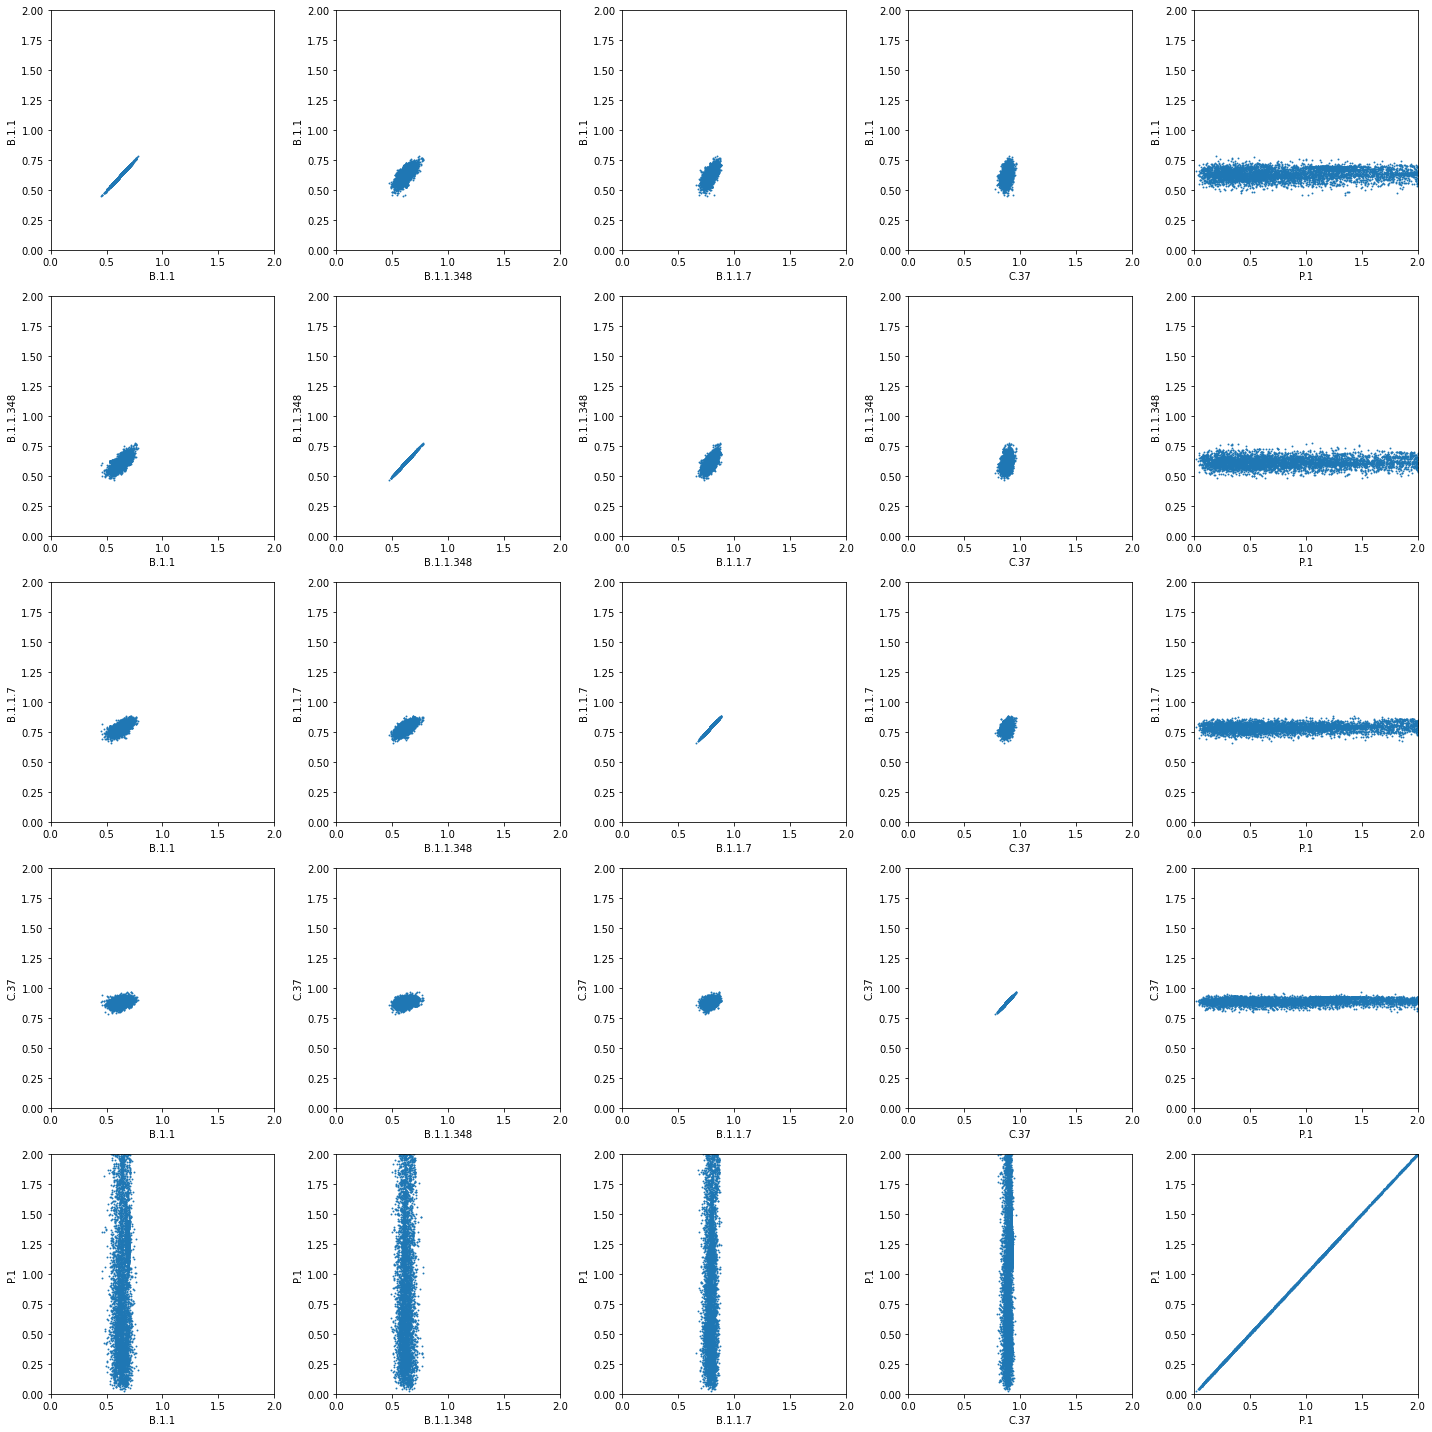

In [40]:
fig,axes = plt.subplots(len(variant_names),len(variant_names),figsize=(20,20))
for i in range(len(variant_names)):
    for j in range(len(variant_names)):
        x = np.array(trace.posterior.f_v[:,:,j]).flatten()
        y = np.array(trace.posterior.f_v[:,:,i]).flatten()
        axes[i,j].scatter(x,y, s=0.8)
        axes[i,j].set_xlim(0,2)
        axes[i,j].set_ylim(0,2)
        axes[i,j].set_xlabel(variant_names[j])
        axes[i,j].set_ylabel(variant_names[i])
fig.tight_layout()